<a href="https://colab.research.google.com/github/Junaidirah/predictive_pm25/blob/master/notebook/eda_gku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

In [62]:
# path = "D:\development\predictive_pm25\data\data_training\TUTL_RAW_2023-2025.csv"
path = "/content/GKU_RAW_2023-2025.csv"

In [63]:
df = pd.read_csv(path)

In [64]:
print(f"Data awal: {df['created_at'].min()}")
print(f"Data akhir: {df['created_at'].max()}")
df.tail()

Data awal: 2023-01-24 18:22:56
Data akhir: 2025-11-24 11:58:00


,id,created_at,temperature,humidity,sht31_temp,sht31_hum,co2,pm25,ws,wd,pressure,solar
700451,716661,2025-11-24 11:50:00,33.61,41.0,32.68,55.0,464.10,29.0,6.95,266.0,NaN,NaN
700452,716662,2025-11-24 11:52:00,33.64,42.0,32.67,56.0,461.11,31.0,5.62,289.0,NaN,NaN
700453,716663,2025-11-24 11:54:00,33.38,43.0,32.84,56.0,463.13,33.0,7.28,289.0,NaN,NaN
700454,716664,2025-11-24 11:56:00,33.62,41.0,33.37,53.0,466.09,27.0,3.27,267.0,NaN,NaN
700455,716665,2025-11-24 11:58:00,33.95,43.0,33.80,55.0,473.05,30.0,6.95,22.0,NaN,NaN


## EXPLORE DATA BEFORE NORMALIZE AND VALIDATION

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700456 entries, 0 to 700455
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           700456 non-null  int64  
 1   created_at   700456 non-null  object 
 2   temperature  691645 non-null  float64
 3   humidity     691733 non-null  float64
 4   sht31_temp   668700 non-null  float64
 5   sht31_hum    613406 non-null  float64
 6   co2          699654 non-null  float64
 7   pm25         699689 non-null  float64
 8   ws           324690 non-null  float64
 9   wd           324714 non-null  float64
 10  pressure     106431 non-null  float64
 11  solar        0 non-null       float64
dtypes: float64(10), int64(1), object(1)
memory usage: 64.1+ MB


In [66]:
duplicated_rows = df[df.duplicated()]
print(f"Number of duplicated rows: {len(duplicated_rows)}")

Number of duplicated rows: 0


In [67]:
df.describe()

,id,temperature,humidity,sht31_temp,sht31_hum,co2,pm25,ws,wd,pressure,solar
count,700456.000000,691645.000000,6.917330e+05,668700.000000,613406.000000,699654.000000,699689.000000,324690.000000,324714.000000,106431.000000,0.0
mean,360000.416359,26.559500,4.353796e+04,15.284425,50.322367,862.640771,68.911752,3.695102,162.509965,82044.369778,NaN
std,208823.751451,42.656315,9.660966e+06,49.185798,298.523715,1576.212822,602.232001,8.378680,95.617261,22312.955801,NaN
min,1.000000,-6.070000,0.000000e+00,-4.630000,0.000000,-1250.000000,0.000000,0.000000,0.000000,-7220.890000,NaN
25%,175114.750000,23.000000,6.080000e+01,0.000000,1.780000,606.550000,32.000000,1.830000,89.000000,75167.270000,NaN
50%,364499.500000,25.000000,7.830000e+01,20.940000,62.259930,750.859990,50.000000,2.990000,135.000000,93110.200000,NaN
75%,541391.250000,29.810000,9.080000e+01,24.695580,91.000000,888.320010,82.000000,4.830000,247.000000,93362.990000,NaN
max,716665.000000,35300.000000,2.147484e+09,30390.000000,100204.000000,754296.000000,93089.000000,3381.000000,359.000000,224681.660000,NaN


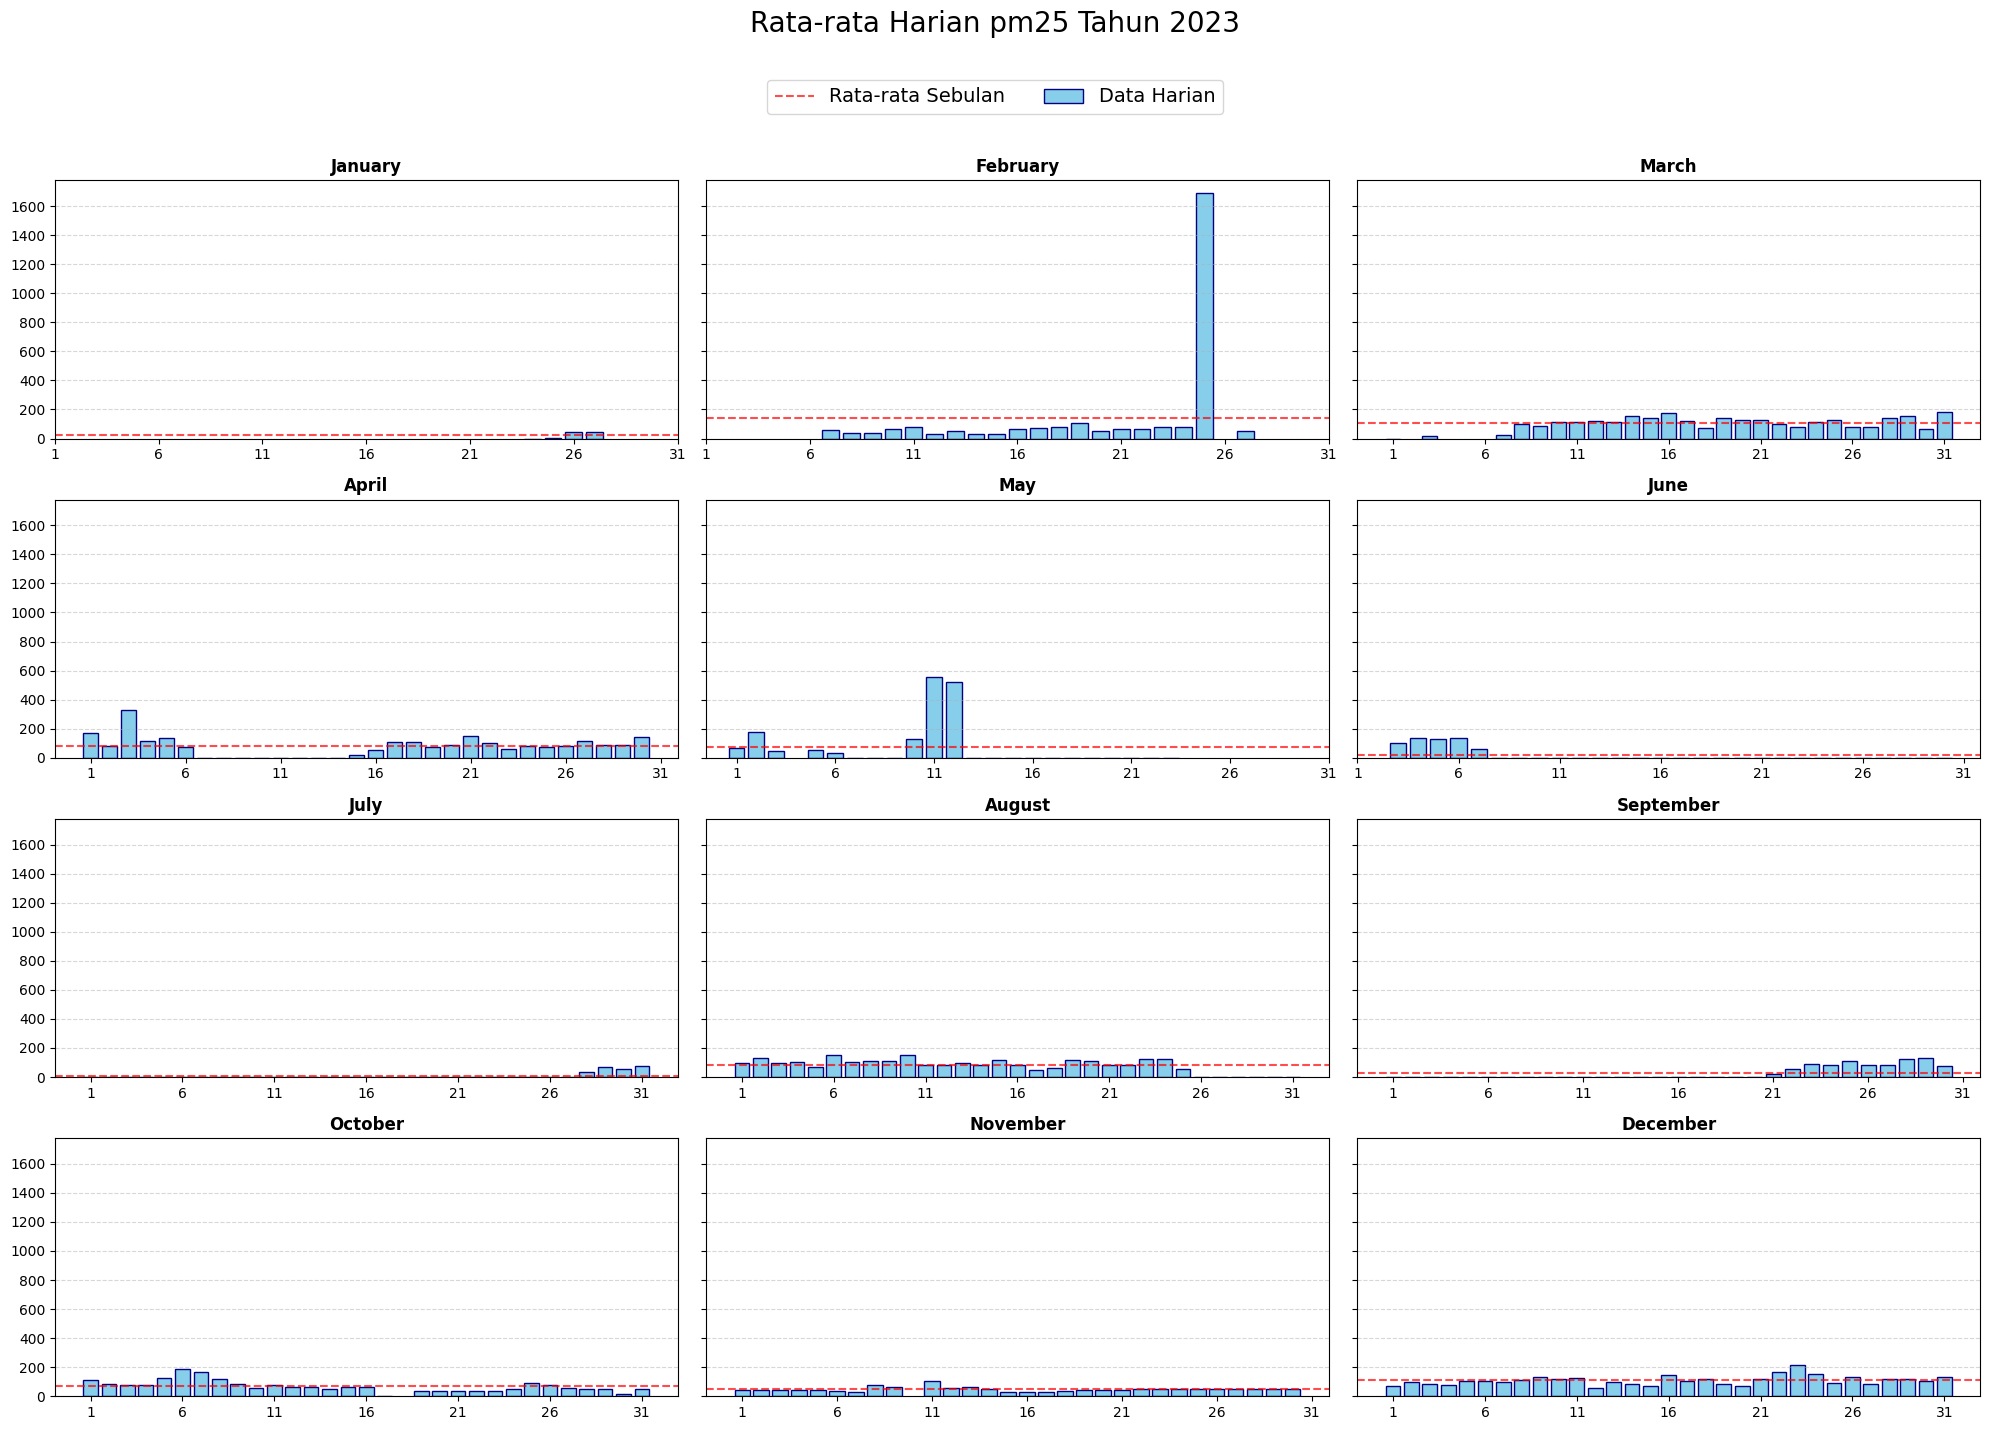

In [68]:
import calendar
df['created_at'] = pd.to_datetime(df['created_at'])
df_2023 = df[df['created_at'].dt.year == 2023].copy()
df_2023 = df_2023.set_index('created_at')

# Fix: Added numeric_only=True to skip non-numeric columns like 'date'
daily_avg = df_2023.resample('D').mean(numeric_only=True)
daily_avg = daily_avg.round(1)
kolom_target = 'pm25'

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15), sharey=True)
fig.suptitle(f'Rata-rata Harian {kolom_target} Tahun 2023', fontsize=20)

axes = axes.flatten()

for i in range(1, 13):
    data_bulan = daily_avg[daily_avg.index.month == i]
    ax = axes[i-1]

    if not data_bulan.empty:
        ax.bar(data_bulan.index.day, data_bulan[kolom_target],
               color='skyblue', edgecolor='navy', label='Data Harian')

        rata_rata_bulan = data_bulan[kolom_target].mean()
        ax.axhline(y=rata_rata_bulan, color='red', linestyle='--', alpha=0.7, label='Rata-rata Sebulan')

    nama_bulan = calendar.month_name[i]
    ax.set_title(nama_bulan, fontsize=12, fontweight='bold')
    ax.set_xticks(range(1, 32, 5))
    ax.grid(axis='y', linestyle='--', alpha=0.5)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.94), fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.92])
plt.show()

### Data Cleaning


In [69]:
total_rows = len(df)
missing = df.isnull().sum()
present = df.notnull().sum()
pct_missing = (missing / total_rows) * 100
quality_report = pd.DataFrame({
    'Data Hilang': missing,
    'Data Tersedia': present,
    'Total Seharusnya': total_rows,
    '% Hilang': pct_missing
})
print(quality_report.sort_values(by='% Hilang', ascending=False))

             Data Hilang  Data Tersedia  Total Seharusnya    % Hilang
solar             700456              0            700456  100.000000
pressure          594025         106431            700456   84.805470
ws                375766         324690            700456   53.645911
wd                375742         324714            700456   53.642484
sht31_hum          87050         613406            700456   12.427619
sht31_temp         31756         668700            700456    4.533618
temperature         8811         691645            700456    1.257895
humidity            8723         691733            700456    1.245332
co2                  802         699654            700456    0.114497
pm25                 767         699689            700456    0.109500
id                     0         700456            700456    0.000000
created_at             0         700456            700456    0.000000


In [70]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['year'] = df['created_at'].dt.year
target_cols = ['pm25', 'temperature', 'humidity', 'ws', 'wd','sht31_temp','sht31_hum']

percentage_missing = df.groupby('year')[target_cols].apply(
    lambda x: x.isnull().mean() * 100
)

percentage_missing = percentage_missing.round(2)

percentage_missing = percentage_missing.reset_index()

print("Data Awal (Cuplikan):")
df.head()
print("\n--- Hasil Persentase Data Hilang per Tahun per Kolom ---")
print(percentage_missing)

Data Awal (Cuplikan):

--- Hasil Persentase Data Hilang per Tahun per Kolom ---
   year  pm25  temperature  humidity      ws      wd  sht31_temp  sht31_hum
0  2023  0.00         0.49      0.49  100.00  100.00        2.79      24.48
1  2024  0.00         2.95      2.92   52.36   52.36       10.40      10.40
2  2025  0.35         0.37      0.35    0.36    0.35        0.36       0.37


In [71]:
def get_days_in_year(year):
    if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
        return 366
    return 365

# Menghitung data aktual per tahun
yearly_summary = df.groupby('year').size().reset_index(name='data_aktual')

# Menghitung data ekspektasi (720 data/hari)
yearly_summary['data_seharusnya'] = yearly_summary['year'].apply(lambda y: get_days_in_year(y) * 720)

# Menghitung selisih dan persentase kelengkapan
yearly_summary['selisih'] = yearly_summary['data_seharusnya'] - yearly_summary['data_aktual']
yearly_summary['persentase_kelengkapan'] = (yearly_summary['data_aktual'] / yearly_summary['data_seharusnya'] * 100).round(2)

print("--- Perbandingan Data Aktual vs Ekspektasi Per Tahun ---")
display(yearly_summary)

--- Perbandingan Data Aktual vs Ekspektasi Per Tahun ---


,year,data_aktual,data_seharusnya,selisih,persentase_kelengkapan
0,2023,254866,262800,7934,96.98
1,2024,229391,263520,34129,87.05
2,2025,216199,262800,46601,82.27


In [72]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['date'] = df['created_at'].dt.date
df['year'] = df['created_at'].dt.year
daily_counts = df.groupby('date').size().reset_index(name='actual_count')
EXPECTED_DAILY = 720
daily_counts['expected_count'] = EXPECTED_DAILY
daily_counts['missing_count'] = daily_counts['expected_count'] - daily_counts['actual_count']
daily_counts['completeness_pct'] = (daily_counts['actual_count'] / daily_counts['expected_count']) * 100
daily_counts['completeness_pct'] = daily_counts['completeness_pct'].round(2)

def categorize_status(pct):
    if pct >= 99: return 'Sangat Baik'
    elif pct >= 90: return 'Baik'
    elif pct >= 50: return 'Kurang'
    else: return 'Kritis'

daily_counts['status'] = daily_counts['completeness_pct'].apply(categorize_status)

print("--- Contoh Hasil Pengecekan Harian ---")
print(daily_counts.head())

def get_yearly_expected(year):
    if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
        days = 366
    else:
        days = 365
    return days * 720
# Group by tahun
yearly_stats = df.groupby('year').size().reset_index(name='actual_total')
yearly_stats['expected_total'] = yearly_stats['year'].apply(get_yearly_expected)

# Hitung gap tahunan
yearly_stats['gap_total'] = yearly_stats['expected_total'] - yearly_stats['actual_total']
yearly_stats['completeness_pct'] = (yearly_stats['actual_total'] / yearly_stats['expected_total']) * 100
yearly_stats['completeness_pct'] = yearly_stats['completeness_pct'].round(2)

print("\n--- Rekap Kelengkapan Data Per Tahun ---")
print(yearly_stats)

# --- OPSIONAL: MELIHAT HARI DENGAN DATA PALING SEDIKIT ---
print("\n--- 5 Hari dengan Data Paling Sedikit (Terburuk) ---")
print(daily_counts.sort_values('actual_count').head(5))


--- Contoh Hasil Pengecekan Harian ---
         date  actual_count  expected_count  missing_count  completeness_pct  \
0  2023-01-24             5             720            715              0.69   
1  2023-01-25            39             720            681              5.42   
2  2023-01-26            10             720            710              1.39   
3  2023-01-27             8             720            712              1.11   
4  2023-02-07            25             720            695              3.47   

   status  
0  Kritis  
1  Kritis  
2  Kritis  
3  Kritis  
4  Kritis  

--- Rekap Kelengkapan Data Per Tahun ---
   year  actual_total  expected_total  gap_total  completeness_pct
0  2023        254866          262800       7934             96.98
1  2024        229391          263520      34129             87.05
2  2025        216199          262800      46601             82.27

--- 5 Hari dengan Data Paling Sedikit (Terburuk) ---
           date  actual_count  expected_coun

In [73]:
overload_days = daily_counts[daily_counts['actual_count'] > 720].sort_values('actual_count', ascending=False)

print(f"Ditemukan {len(overload_days)} hari dengan data berlebih:")

if not overload_days.empty:
    print(overload_days[['date', 'actual_count', 'missing_count', 'status']])
else:
    print("Sempurna. Tidak ada hari dengan data berlebih (double/spam).")

overload_days.head()

Ditemukan 231 hari dengan data berlebih:
           date  actual_count  missing_count       status
165  2023-08-04           958           -238  Sangat Baik
163  2023-08-02           958           -238  Sangat Baik
175  2023-08-14           958           -238  Sangat Baik
177  2023-08-16           958           -238  Sangat Baik
174  2023-08-13           958           -238  Sangat Baik
..          ...           ...            ...          ...
261  2023-11-09           769            -49  Sangat Baik
960  2025-10-29           744            -24  Sangat Baik
949  2025-10-18           726             -6  Sangat Baik
956  2025-10-25           725             -5  Sangat Baik
852  2025-07-13           723             -3  Sangat Baik

[231 rows x 4 columns]


,date,actual_count,expected_count,missing_count,completeness_pct,status
165,2023-08-04,958,720,-238,133.06,Sangat Baik
163,2023-08-02,958,720,-238,133.06,Sangat Baik
175,2023-08-14,958,720,-238,133.06,Sangat Baik
177,2023-08-16,958,720,-238,133.06,Sangat Baik
174,2023-08-13,958,720,-238,133.06,Sangat Baik


In [74]:
# 1. Pastikan kolom tahun dan missing_count tersedia
daily_counts['year'] = pd.to_datetime(daily_counts['date']).dt.year
daily_counts['missing_count'] = 720 - daily_counts['actual_count']

# 2. Filter hanya hari-hari yang overload (> 720)
problematic_days = daily_counts[daily_counts['actual_count'] > 720].copy()

# 3. Hitung berapa banyak hari seperti itu di setiap tahun
summary_overload = problematic_days.groupby('year').agg(
    jumlah_hari_overload=('date', 'count'),
    total_data_berlebih=('missing_count', lambda x: abs(x).sum())
).reset_index()

# 4. Tambahkan perbandingan dengan total hari yang ada di data
total_days_per_year = daily_counts.groupby('year').size().reset_index(name='total_hari_terekam')
summary_overload = summary_overload.merge(total_days_per_year, on='year')

# 5. Hitung persentase kerusakan
summary_overload['persentase_hari_rusak'] = (summary_overload['jumlah_hari_overload'] / summary_overload['total_hari_terekam'] * 100).round(2)

print("--- Laporan Kerusakan Data Tahunan ---")
display(summary_overload)

--- Laporan Kerusakan Data Tahunan ---


,year,jumlah_hari_overload,total_data_berlebih,total_hari_terekam,persentase_hari_rusak
0,2023,195,43957,313,62.30
1,2024,32,7241,350,9.14
2,2025,4,38,320,1.25


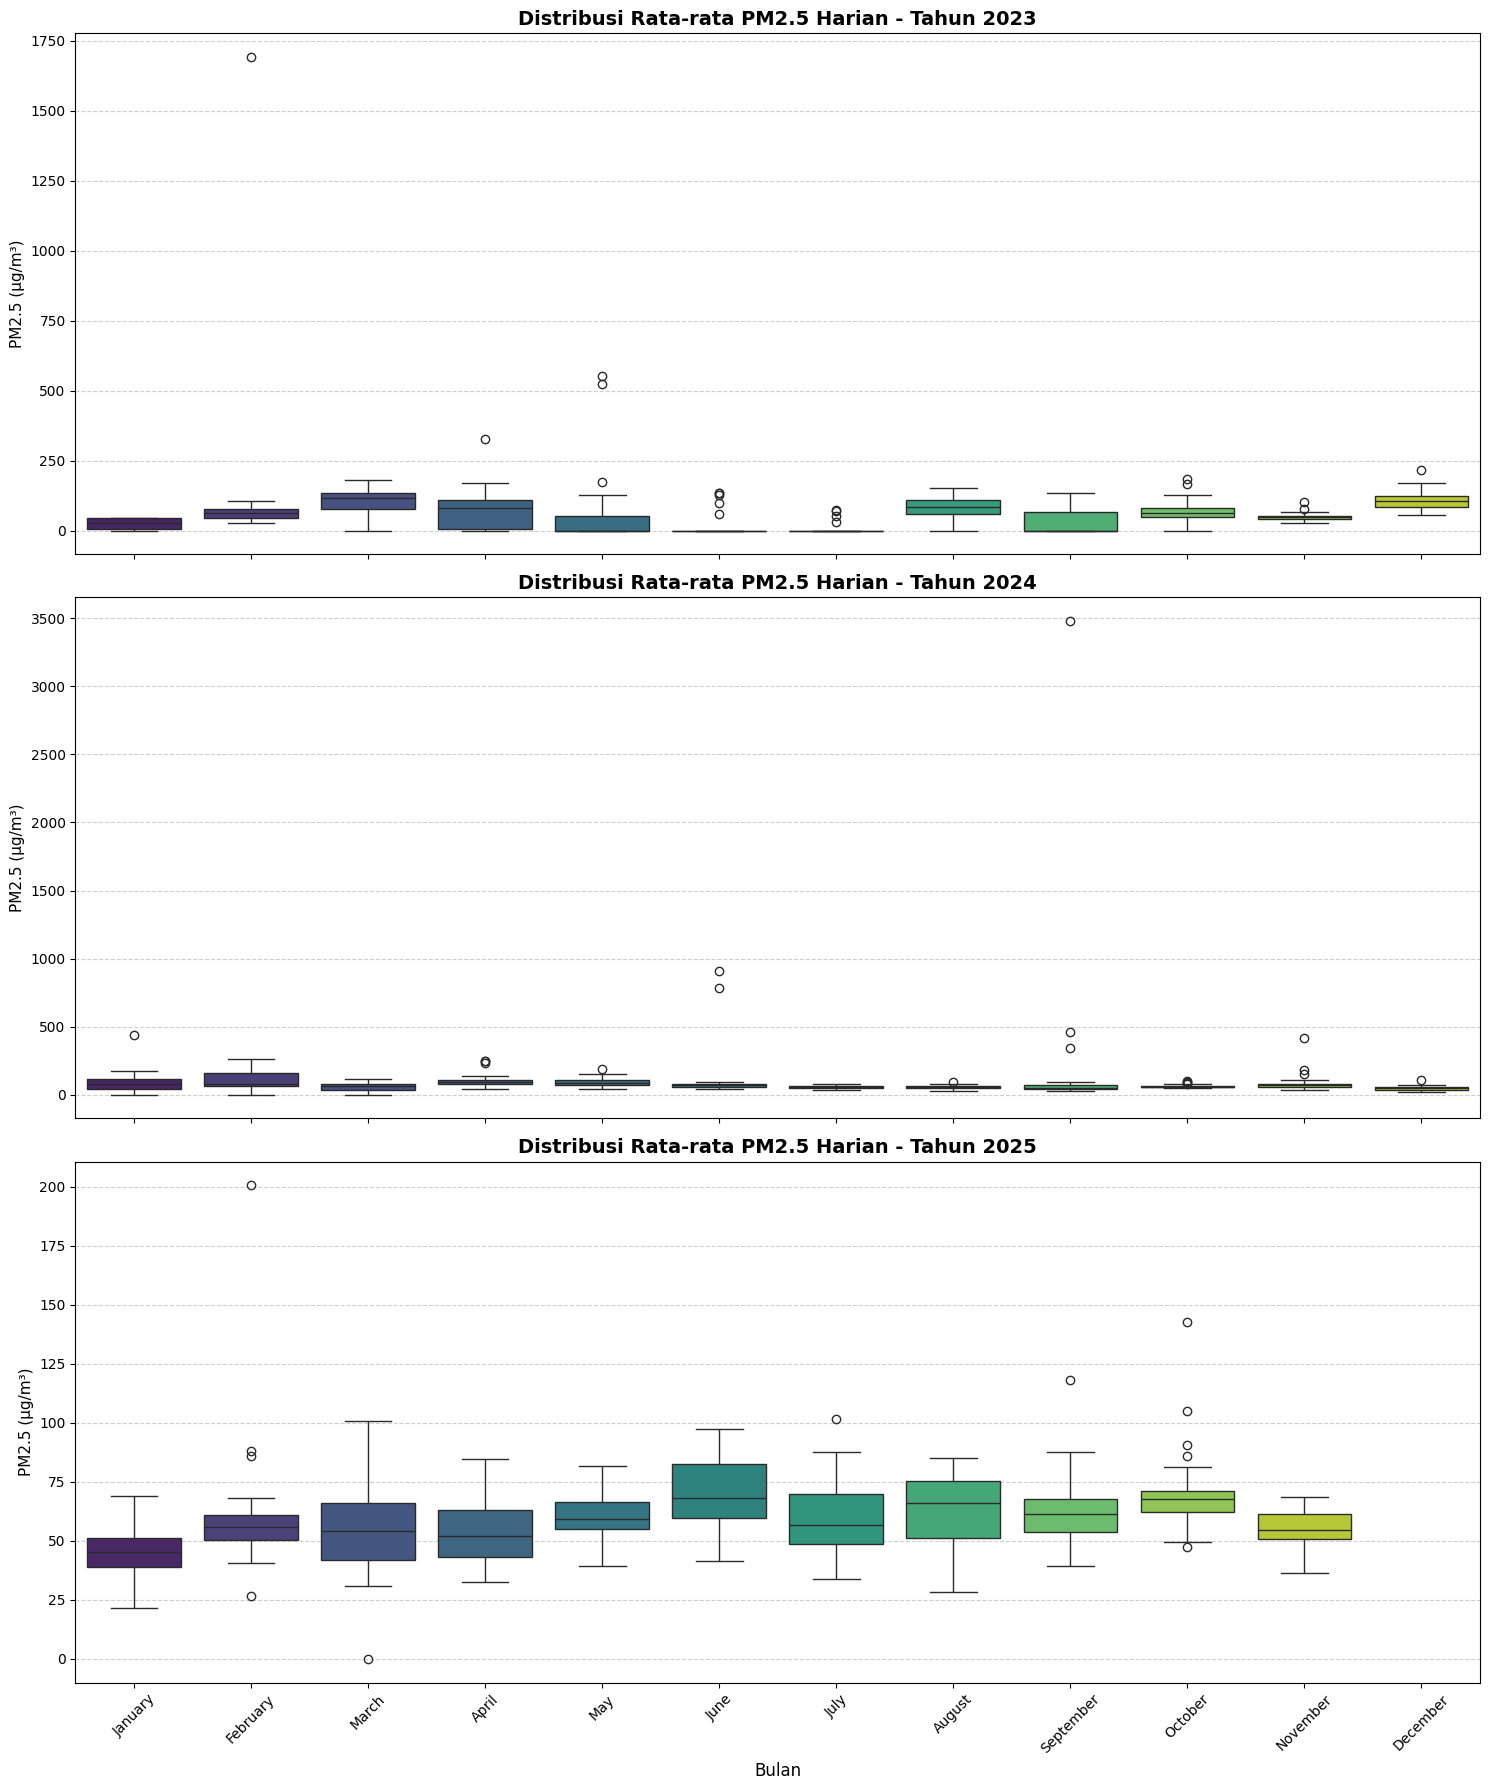

In [75]:
# 1. Persiapkan data harian dan kolom tahun
daily_pm25 = df.groupby('date')['pm25'].mean().reset_index()
daily_pm25['date'] = pd.to_datetime(daily_pm25['date'])
daily_pm25['year'] = daily_pm25['date'].dt.year
daily_pm25['month_name'] = daily_pm25['date'].dt.month_name()

# Urutan bulan agar rapi
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# 2. Visualisasi Box Plot per Tahun (2023, 2024, 2025)
years_to_plot = [2023, 2024, 2025]
fig, axes = plt.subplots(3, 1, figsize=(15, 18), sharex=True)

for i, year in enumerate(years_to_plot):
    data_year = daily_pm25[daily_pm25['year'] == year]
    if not data_year.empty:
        sns.boxplot(ax=axes[i], x='month_name', y='pm25', data=data_year,
                    order=month_order, hue='month_name', palette='viridis', legend=False)
        axes[i].set_title(f'Distribusi Rata-rata PM2.5 Harian - Tahun {year}', fontsize=14, fontweight='bold')
        axes[i].set_ylabel('PM2.5 (µg/m³)', fontsize=11)
        axes[i].grid(axis='y', linestyle='--', alpha=0.6)
    else:
        axes[i].set_title(f'Data Tahun {year} Tidak Tersedia', fontsize=14)

plt.xlabel('Bulan', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [76]:
# Menampilkan cuplikan dataframe utama (df) yang paling update
print(f"Ukuran dataframe saat ini: {df.shape}")
display(df.head())

Ukuran dataframe saat ini: (700456, 14)


,id,created_at,temperature,humidity,sht31_temp,sht31_hum,co2,pm25,ws,wd,pressure,solar,year,date
0,1,2023-01-24 18:22:56,NaN,NaN,0.0,NaN,3162.50000,0.0,NaN,NaN,NaN,NaN,2023,2023-01-24
1,2,2023-01-24 18:29:20,0.0,0.0,0.0,NaN,0.00000,0.0,NaN,NaN,NaN,NaN,2023,2023-01-24
2,3,2023-01-24 18:34:01,0.0,0.0,0.0,NaN,0.00000,0.0,NaN,NaN,NaN,NaN,2023,2023-01-24
3,4,2023-01-24 18:35:01,NaN,NaN,0.0,NaN,4675.00000,0.0,NaN,NaN,NaN,NaN,2023,2023-01-24
4,5,2023-01-24 20:33:26,NaN,NaN,0.0,NaN,5040.62988,0.0,NaN,NaN,NaN,NaN,2023,2023-01-24


In [77]:
df['created_at']= pd.to_datetime(df['created_at'])
df_drop_2023 = df[df['created_at'].dt.year != 2023]
index_to_drop = df[df['created_at'].dt.year == 2023].index
df.drop(index_to_drop, inplace=True)
print("Data setelah menghapus tahun 2023:")
df.tail()

Data setelah menghapus tahun 2023:


,id,created_at,temperature,humidity,sht31_temp,sht31_hum,co2,pm25,ws,wd,pressure,solar,year,date
700451,716661,2025-11-24 11:50:00,33.61,41.0,32.68,55.0,464.10,29.0,6.95,266.0,NaN,NaN,2025,2025-11-24
700452,716662,2025-11-24 11:52:00,33.64,42.0,32.67,56.0,461.11,31.0,5.62,289.0,NaN,NaN,2025,2025-11-24
700453,716663,2025-11-24 11:54:00,33.38,43.0,32.84,56.0,463.13,33.0,7.28,289.0,NaN,NaN,2025,2025-11-24
700454,716664,2025-11-24 11:56:00,33.62,41.0,33.37,53.0,466.09,27.0,3.27,267.0,NaN,NaN,2025,2025-11-24
700455,716665,2025-11-24 11:58:00,33.95,43.0,33.80,55.0,473.05,30.0,6.95,22.0,NaN,NaN,2025,2025-11-24


## Normalize, cleaning, and validation data

In [78]:
df.head()

,id,created_at,temperature,humidity,sht31_temp,sht31_hum,co2,pm25,ws,wd,pressure,solar,year,date
254866,254867,2024-01-01 00:00:46,22.0,99.9,0.0,1.84,934.14001,195.0,NaN,NaN,NaN,NaN,2024,2024-01-01
254867,254868,2024-01-01 00:02:17,22.0,99.9,0.0,1.84,934.14001,195.0,NaN,NaN,NaN,NaN,2024,2024-01-01
254868,254871,2024-01-01 00:06:47,22.0,99.9,0.0,1.84,1147.96997,195.0,NaN,NaN,NaN,NaN,2024,2024-01-01
254869,254872,2024-01-01 00:08:18,22.0,99.9,0.0,1.84,1147.96997,195.0,NaN,NaN,NaN,NaN,2024,2024-01-01
254870,254875,2024-01-01 00:12:48,21.9,99.9,0.0,1.83,1086.88000,195.0,NaN,NaN,NaN,NaN,2024,2024-01-01


In [79]:
columns_to_drop = ['co2', 'pressure', 'solar', 'ws', 'wd']
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
print(f"Columns dropped (or already missing): {columns_to_drop}")
df.head(10)

Columns dropped (or already missing): ['co2', 'pressure', 'solar', 'ws', 'wd']


,id,created_at,temperature,humidity,sht31_temp,sht31_hum,pm25,year,date
254866,254867,2024-01-01 00:00:46,22.0,99.9,0.0,1.84,195.0,2024,2024-01-01
254867,254868,2024-01-01 00:02:17,22.0,99.9,0.0,1.84,195.0,2024,2024-01-01
254868,254871,2024-01-01 00:06:47,22.0,99.9,0.0,1.84,195.0,2024,2024-01-01
254869,254872,2024-01-01 00:08:18,22.0,99.9,0.0,1.84,195.0,2024,2024-01-01
254870,254875,2024-01-01 00:12:48,21.9,99.9,0.0,1.83,195.0,2024,2024-01-01
254871,254876,2024-01-01 00:14:19,21.9,99.9,0.0,1.83,195.0,2024,2024-01-01
254872,254879,2024-01-01 00:18:49,21.8,99.9,0.0,1.83,195.0,2024,2024-01-01
254873,254880,2024-01-01 00:20:19,21.8,99.9,0.0,1.83,195.0,2024,2024-01-01
254874,254883,2024-01-01 00:24:50,21.7,99.9,0.0,1.83,195.0,2024,2024-01-01
254875,254884,2024-01-01 00:26:20,21.7,99.9,0.0,1.83,195.0,2024,2024-01-01


#### Validation Data

In [ ]:
import pandas as pd
import numpy as np

# ==========================================
# SETUP & CONVERSION
# ==========================================

if 'created_at' in df.columns:
    df['created_at'] = pd.to_datetime(df['created_at'])
    df = df.sort_values('created_at')
else:
    raise ValueError("Kolom 'created_at' tidak ditemukan!")

# Column mapping - UPDATED dengan sht31_temp dan sht31_hum
column_mapping = {
    'pm25': 'pm2_5',
    'temperature': 'temp',
    'humidity': 'hum',
    'sht31_temp': 'sht31_temp',      # BARU: SHT31 Temperature
    'sht31_hum': 'sht31_hum',        # BARU: SHT31 Humidity
}

# Batas Fisik (Hard Limit) - UPDATED
# sht31_temp dan sht31_hum memiliki range yang sama dengan temp dan hum
RANGE_LIMITS = {
    'pm2_5': (0, 250),           # PM2.5: 0-250 µg/m³
    'temp': (0, 80),             # Temperature: 0-80°C
    'hum': (0, 100),             # Humidity: 0-100%
    'sht31_temp': (0, 80),       # SHT31 Temp: 0-80°C (sama dengan temp)
    'sht31_hum': (0, 100),       # SHT31 Hum: 0-100% (sama dengan hum)
}

print("\n" + "=" * 70)
print("📊 PARAMETER KONFIGURASI")
print("=" * 70)
print("\n📋 Kolom yang akan divalidasi:")
for col, mapped_name in column_mapping.items():
    if col in df.columns:
        limit = RANGE_LIMITS.get(mapped_name, "N/A")
        print(f"   {col:15} → {mapped_name:12} | Range: {limit}")
    else:
        print(f"   {col:15} → {mapped_name:12} | ⚠️ TIDAK ADA DI DATA")

# Convert to numeric
for col_name in column_mapping.keys():
    if col_name in df.columns:
        df[col_name] = pd.to_numeric(df[col_name], errors='coerce')
        print(f"   ✓ {col_name} converted to numeric")

# ==========================================
# 2. KONFIGURASI
# ==========================================
EXPECTED_DATA_PER_HOUR = 30   # Asumsi data per 2 menit
THRESHOLD_PERCENTAGE = 0.75   # 75%
MIN_DATA_COUNT = int(EXPECTED_DATA_PER_HOUR * THRESHOLD_PERCENTAGE) # 22 Data

WINDOW_SIZE = 10
K_FACTOR = 1.5

print("\n" + "=" * 70)
print("⚙️ KONFIGURASI VALIDASI")
print("=" * 70)
print(f"Expected data per hour: {EXPECTED_DATA_PER_HOUR}")
print(f"Threshold percentage: {THRESHOLD_PERCENTAGE * 100}%")
print(f"Minimum data count: {MIN_DATA_COUNT} data/batch")
print(f"Sliding window size: {WINDOW_SIZE}")
print(f"K-factor (IQR multiplier): {K_FACTOR}")

# ==========================================
# 3. FUNGSI DETEKSI OUTLIER (Hard Limit + Statistik)
# ==========================================
def identify_outliers_sliding_window(data_series, window_size, k, limits=None):
    """
    Deteksi outlier dengan 2 tahap:
    1. Hard Limit: Cek range fisik
    2. Statistik: IQR sliding window
    """
    is_outlier = pd.Series(False, index=data_series.index)
    min_limit, max_limit = None, None

    # Unpack limit jika ada
    if limits:
        min_limit, max_limit = limits

    for i in range(len(data_series)):
        current_val = data_series.iloc[i]

        # Skip jika data kosong (NaN)
        if pd.isna(current_val):
            continue

        # --- TAHAP 1: Hard Limit (Validasi Range Fisik) ---
        if limits:
            if current_val < min_limit or current_val > max_limit:
                is_outlier.iloc[i] = True
                continue

        # --- TAHAP 2: Statistik Sliding Window ---
        window_start = max(0, i - window_size + 1)
        window_end = i + 1
        window_data = data_series.iloc[window_start:window_end].dropna()

        # Minimal 5 data valid untuk hitung statistik
        if len(window_data) > 5:
            Q1 = window_data.quantile(0.25)
            Q3 = window_data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - k * IQR
            upper_bound = Q3 + k * IQR

            if current_val < lower_bound or current_val > upper_bound:
                is_outlier.iloc[i] = True

    return is_outlier

# ==========================================
# 4. EKSEKUSI VALIDASI (Dynamic Time Window)
# ==========================================

print(f"\nTotal data awal: {len(df)}")
print(f"Syarat Kelengkapan: Minimal {MIN_DATA_COUNT} data per batch (75%).")
print("-" * 70)

valid_batches = []
incomplete_batches = []  # Untuk tracking batch yang tidak lengkap

# Grouper dengan origin='start'
grouper = pd.Grouper(key='created_at', freq='1h', origin='start')

for time_range, group_data in df.groupby(grouper):

    jumlah_data_aktual = len(group_data)

    if jumlah_data_aktual == 0:
        continue

    # Hitung waktu selesai batch
    end_time = time_range + pd.Timedelta(hours=1)

    # --- CEK A: KELENGKAPAN DATA (75%) ---
    if jumlah_data_aktual < MIN_DATA_COUNT:
        print(f"⚠️ [INCOMPLETE] Batch {time_range.time()} - {end_time.time()}: "
              f"{jumlah_data_aktual} data (Kurang dari 75%). "
              f"Data akan diubah menjadi NaN untuk imputation.")

        # Ubah SEMUA nilai dalam batch ini menjadi NaN
        group_data_nan = group_data.copy()

        # Ganti nilai dari kolom measured (bukan timestamp)
        # UPDATED: termasuk sht31_temp dan sht31_hum
        for col in ['pm25', 'temperature', 'humidity', 'sht31_temp', 'sht31_hum']:
            if col in group_data_nan.columns:
                group_data_nan[col] = np.nan

        incomplete_batches.append(group_data_nan)
        print(f"   └─ Seluruh nilai dalam batch diubah ke NaN")

        continue

    else:
        # --- CEK B: VALIDITAS NILAI (Range & Outlier) ---
        print(f"✅ [PROCESS] Batch {time_range.time()} - {end_time.time()}: "
              f"{jumlah_data_aktual} data. Checking value validity...")

        group_clean = group_data.copy()
        rows_to_drop_mask = pd.Series(False, index=group_clean.index)

        # UPDATED: loop melalui semua kolom termasuk sht31
        for col_df, key_limit in column_mapping.items():
            if col_df in group_clean.columns:
                if group_clean[col_df].isna().all():
                    continue

                limits = RANGE_LIMITS[key_limit]

                col_outliers = identify_outliers_sliding_window(
                    group_clean[col_df],
                    WINDOW_SIZE,
                    K_FACTOR,
                    limits=limits
                )

                rows_to_drop_mask = rows_to_drop_mask | col_outliers

        # Ubah baris yang invalid menjadi NaN (bukan dihapus)
        group_final = group_data.copy()

        # UPDATED: termasuk sht31_temp dan sht31_hum
        for col in ['pm25', 'temperature', 'humidity', 'sht31_temp', 'sht31_hum']:
            if col in group_final.columns:
                group_final.loc[rows_to_drop_mask, col] = np.nan

        valid_batches.append(group_final)

        deleted = rows_to_drop_mask.sum()
        print(f"   └─ {deleted} nilai (Out of range / Outlier) diubah ke NaN. "
              f"Sisa {(~rows_to_drop_mask).sum()} data valid.")

print("-" * 70)

# ==========================================
# 5. GABUNG DATA (Complete + Incomplete)
# ==========================================

all_batches = valid_batches + incomplete_batches

if all_batches:
    df_final_clean = pd.concat(all_batches, sort=False)
    df_final_clean = df_final_clean.sort_values('created_at')

    print("\n" + "=" * 70)
    print("📊 STATISTIK SETELAH VALIDASI (Sebelum Imputation)")
    print("=" * 70)

    print(f"\n✅ Data Lengkap (≥75%):  {len(valid_batches)} batch")
    print(f"⚠️  Data Tidak Lengkap (<75%): {len(incomplete_batches)} batch")

    total_rows = len(df_final_clean)
    # UPDATED: termasuk sht31_temp dan sht31_hum
    nan_count = df_final_clean[['pm25', 'temperature', 'humidity', 'sht31_temp', 'sht31_hum']].isna().sum()

    print(f"\n📋 Total Baris: {total_rows}")
    print(f"📊 NaN Count per kolom:")
    print(f"   PM2.5:       {nan_count.get('pm25', 0):3} NaN ({(nan_count.get('pm25', 0)/total_rows*100):5.2f}%)")
    print(f"   Temperature: {nan_count.get('temperature', 0):3} NaN ({(nan_count.get('temperature', 0)/total_rows*100):5.2f}%)")
    print(f"   Humidity:    {nan_count.get('humidity', 0):3} NaN ({(nan_count.get('humidity', 0)/total_rows*100):5.2f}%)")
    print(f"   SHT31 Temp:  {nan_count.get('sht31_temp', 0):3} NaN ({(nan_count.get('sht31_temp', 0)/total_rows*100):5.2f}%)")
    print(f"   SHT31 Hum:   {nan_count.get('sht31_hum', 0):3} NaN ({(nan_count.get('sht31_hum', 0)/total_rows*100):5.2f}%)")

    # ==========================================
    # 6. KOREKSI PM2.5 BERDASARKAN KELEMBABAN
    # ==========================================
    print("\n" + "=" * 70)
    print("🔧 TAHAP 6: KOREKSI PM2.5 BERDASARKAN KELEMBABAN")
    print("=" * 70)

    print("\n📌 Menggunakan humidity dari kolom 'humidity' untuk koreksi")
    print("   (Alternatif: dapat juga menggunakan sht31_hum jika humidity kosong)")

    # Hitung data sebelum koreksi (yang bukan NaN)
    valid_humidity_mask = df_final_clean['humidity'].notna()
    high_humidity_count = ((df_final_clean['humidity'] > 60) & valid_humidity_mask).sum()

    # Koreksi PM2.5 - HANYA untuk yang bukan NaN dan humidity > 60%
    correction_mask = (df_final_clean['humidity'] > 60) & (df_final_clean['pm25'].notna())
    df_final_clean.loc[correction_mask, 'pm25'] = \
        (df_final_clean.loc[correction_mask, 'pm25'] * 0.67).round(2)

    print(f"\n✅ Data dengan humidity > 60% yang dikoreksi: {correction_mask.sum()} baris")
    print(f"✅ Faktor koreksi: × 0.67")
    print(f"✅ Metode: Hanya koreksi nilai yang valid (bukan NaN)")

    # ==========================================
    # 7. REKAPITULASI AKHIR
    # ==========================================
    print("\n" + "=" * 70)
    print("📋 REKAPITULASI AKHIR")
    print("=" * 70)

    print(f"\nData Awal:              {len(df)} baris")
    print(f"Data Akhir:             {len(df_final_clean)} baris")
    print(f"Data Tertahan:          {len(df_final_clean)} baris (100%)")
    print(f"Data Hilang:            0 baris (0%)")
    print(f"Pendekatan:             NaN untuk missing/invalid values")

    print(f"\n📊 Persentase NaN (Missing Values):")
    total_nan = df_final_clean[['pm25', 'temperature', 'humidity', 'sht31_temp', 'sht31_hum']].isna().sum().sum()
    total_values = total_rows * 5
    print(f"   Total NaN: {total_nan} dari {total_values} values ({(total_nan/total_values*100):.2f}%)")
    print(f"   Siap untuk imputation dengan berbagai metode")

    print("\n🎯 OPSI IMPUTATION (Pilih salah satu):")
    print(f"   1. Forward Fill:     df.fillna(method='ffill')")
    print(f"   2. Backward Fill:    df.fillna(method='bfill')")
    print(f"   3. Interpolation:    df.interpolate(method='linear')")
    print(f"   4. Mean per Jam:     Isi dengan rata-rata jam tersebut")
    print(f"   5. Custom Method:    Kombinasi dari method di atas")

    print("\n" + "=" * 70)
    print("📋 SAMPLE OUTPUT (10 baris pertama)")
    print("=" * 70)
    display(df_final_clean.head(10))

    print("\n" + "=" * 70)
    print("📋 SAMPLE OUTPUT (Baris dengan NaN untuk imputation)")
    print("=" * 70)
    nan_sample = df_final_clean[df_final_clean['pm25'].isna()].head(10)
    if len(nan_sample) > 0:
        display(nan_sample)
    else:
        print("Tidak ada NaN di kolom PM2.5")

    # ==========================================
    # 8. DOKUMENTASI OPSI IMPUTATION
    # ==========================================
    print("\n" + "=" * 70)
    print("📚 OPSI IMPUTATION UNTUK LANGKAH SELANJUTNYA")
    print("=" * 70)

    print("""
REKOMENDASI: Gunakan Kombinasi Method untuk hasil optimal

# Method A: Simple (Linear Interpolation)
df_final_clean = df_final_clean.interpolate(method='linear', limit_direction='both')

# Method B: Advanced (Kombinasi - Recommended)
# Step 1: Linear interpolation untuk gap kecil
df_final_clean = df_final_clean.interpolate(method='linear', limit=10)

# Step 2: Mean per jam untuk gap menengah
for col in ['pm25', 'temperature', 'humidity', 'sht31_temp', 'sht31_hum']:
    df_final_clean[col] = df_final_clean.groupby(
        df_final_clean['created_at'].dt.hour
    )[col].transform(lambda x: x.fillna(x.mean()))

# Step 3: Forward fill untuk sisa
df_final_clean = df_final_clean.fillna(method='ffill')

# Step 4: Backward fill untuk awal dataset
df_final_clean = df_final_clean.fillna(method='bfill')

# Verify
print(f"Remaining NaN: {df_final_clean.isna().sum().sum()}")

# Save
df_final_clean.to_csv('data_clean_validated_sht31.csv', index=False)
    """)

    print("\n" + "=" * 70)
    print("✨ SELESAI! Data siap untuk imputation.")
    print("=" * 70)

else:
    print("❌ HASIL KOSONG.")
    print("Tidak ada batch data yang sesuai kriteria.")

print("\n" + "=" * 70)
print("📌 CATATAN PENTING")
print("=" * 70)
print("""
✅ Kolom yang divalidasi:
   - pm25 (PM2.5): Range 0-250 µg/m³
   - temperature: Range 0-80°C
   - humidity: Range 0-100%
   - sht31_temp: Range 0-80°C (sensor SHT31)
   - sht31_hum: Range 0-100% (sensor SHT31)

✅ Pendekatan NaN Handling:
   - Batch < 75% → Semua nilai jadi NaN
   - Outlier/Invalid → Nilai jadi NaN
   - Bukan dihapus → Data preserved

✅ Next Step:
   - Pilih method imputation dari opsi di atas
   - Apply imputation ke df_final_clean
   - Verify hasil reasonable
   - Save untuk analisis lanjutan

✅ Data Quality:
   - Tidak ada data yang dihapus (100% preserved)
   - Clear dokumentasi invalid values (NaN)
   - Siap untuk ML/Analysis
""")

Streaming output truncated to the last 5000 lines.
   └─ 11 nilai (Out of range / Outlier) diubah ke NaN. Sisa 18 data valid.
✅ [PROCESS] Batch 12:00:46 - 13:00:46: 30 data. Checking value validity...
   └─ 5 nilai (Out of range / Outlier) diubah ke NaN. Sisa 25 data valid.
✅ [PROCESS] Batch 13:00:46 - 14:00:46: 27 data. Checking value validity...
   └─ 3 nilai (Out of range / Outlier) diubah ke NaN. Sisa 24 data valid.
✅ [PROCESS] Batch 14:00:46 - 15:00:46: 30 data. Checking value validity...
   └─ 7 nilai (Out of range / Outlier) diubah ke NaN. Sisa 23 data valid.
✅ [PROCESS] Batch 15:00:46 - 16:00:46: 30 data. Checking value validity...
   └─ 8 nilai (Out of range / Outlier) diubah ke NaN. Sisa 22 data valid.
✅ [PROCESS] Batch 16:00:46 - 17:00:46: 30 data. Checking value validity...
   └─ 11 nilai (Out of range / Outlier) diubah ke NaN. Sisa 19 data valid.
✅ [PROCESS] Batch 17:00:46 - 18:00:46: 30 data. Checking value validity...
   └─ 10 nilai (Out of range / Outlier) diubah ke NaN

### Valid Data

In [ ]:
df_final_clean.tail(10)

In [ ]:
total_rows = len(df_final_clean)
missing = df_final_clean.isnull().sum()
present = df_final_clean.notnull().sum()
pct_missing = (missing / total_rows) * 100
quality_report = pd.DataFrame({
    'Data Hilang': missing,
    'Data Tersedia': present,
    'Total Seharusnya': total_rows,
    '% Hilang': pct_missing
})
print(quality_report.sort_values(by='% Hilang', ascending=False))

In [ ]:
total_rows = len(df_final_clean)
rows_with_nan = df_final_clean.isna().any(axis=1).sum()
rows_without_nan = total_rows - rows_with_nan

print(f"Total baris: {total_rows}")
print(f"Baris yang mengandung setidaknya satu NaN: {rows_with_nan} ({(rows_with_nan/total_rows*100):.2f}%)")
print(f"Baris yang bersih (tanpa NaN): {rows_without_nan} ({(rows_without_nan/total_rows*100):.2f}%)")

In [ ]:
# Tentukan kolom yang akan dirata-ratakan
target_cols = ['temperature', 'humidity', 'sht31_temp', 'sht31_hum', 'pm25']

# Resample per jam dan ambil rata-rata hanya untuk kolom target
df_hourly = df_final_clean.set_index('created_at')[target_cols].resample('h').mean()
df_hourly = df_hourly.round(2)

# Menambahkan kembali kolom year dari index
df_hourly['year'] = df_hourly.index.year

# Membuat ID baru yang berurutan mulai dari 1 untuk data per jam
df_hourly.insert(0, 'id', range(1, len(df_hourly) + 1))

print(f"Ukuran data setelah resample per jam: {df_hourly.shape}")
df_hourly.tail(10)

In [ ]:
# Memeriksa rentang waktu data yang ada di dataset
print(f"Data paling awal: {df['created_at'].min()}")
print(f"Data paling akhir: {df['created_at'].max()}")

# Menghitung persentase NaN per bulan untuk tahun 2024 - 2025
target_cols = ['temperature', 'humidity', 'sht31_temp', 'sht31_hum', 'pm25']

# Tambahkan kolom pembantu untuk pengelompokan
df_nan_check = df_hourly.copy()
df_nan_check['month'] = df_nan_check.index.month_name()
df_nan_check['year'] = df_nan_check.index.year

# Definisikan urutan bulan agar tampilan rapi
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Hitung persentase NaN per Tahun dan Bulan
nan_percentage_report = df_nan_check.groupby(['year', 'month'])[target_cols].apply(
    lambda x: (x.isnull().mean() * 100).round(2)
).reset_index()

# Mengatur urutan bulan secara logis
nan_percentage_report['month'] = pd.Categorical(nan_percentage_report['month'], categories=month_order, ordered=True)
nan_percentage_report = nan_percentage_report.sort_values(['year', 'month'])

print("\n--- Persentase Nilai NaN per Bulan (2024-2025) ---")
display(nan_percentage_report)

In [ ]:
# Memeriksa jumlah NaN pada df_hourly
target_cols = ['temperature', 'humidity', 'sht31_temp', 'sht31_hum', 'pm25']
missing = df_hourly[target_cols].isnull().sum()
pct_missing = (df_hourly[target_cols].isnull().mean() * 100).round(2)

quality_report = pd.DataFrame({
    'Data Hilang': missing,
    '% Hilang': pct_missing
})

print("--- Laporan Nilai NaN (df_hourly) ---")
print(quality_report)

#### PM25 cleaning

In [ ]:
# Filter data for 2024 and create a copy
df_2024_plot = df_hourly[df_hourly.index.year == 2024].copy()

# Extract month names for the x-axis
df_2024_plot['month_name'] = df_2024_plot.index.month_name()

# Define standard month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Create the visualization
plt.figure(figsize=(15, 7))
sns.boxplot(x='month_name', y='pm25', data=df_2024_plot,
            order=month_order, hue='month_name', palette='viridis', legend=False)

plt.title('Distribusi Rata-rata PM2.5 Per Jam per Bulan - Tahun 2024', fontsize=14, fontweight='bold')
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('PM2.5 (µg/m³)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Menangani outlier menggunakan metode Monthly IQR Clipping (Per Year & Month)
# Kita akan membatasi nilai agar tepat berada di batas whisker masing-masing kelompok tahun-bulan

def cap_outliers_specific(group):
    if group['pm25'].dropna().empty:
        return group

    Q1 = group['pm25'].quantile(0.25)
    Q3 = group['pm25'].quantile(0.75)
    IQR = Q3 - Q1
    upper_whisker = Q3 + 1.5 * IQR
    lower_whisker = Q1 - 1.5 * IQR

    # Lakukan capping ke batas whisker spesifik kelompok ini
    group['pm25'] = group['pm25'].clip(lower=lower_whisker, upper=upper_whisker)
    return group

# Tambahkan kolom pembantu untuk grouping yang lebih detail (Tahun dan Bulan)
df_hourly['temp_year'] = df_hourly.index.year
df_hourly['temp_month'] = df_hourly.index.month

# Terapkan fungsi capping per (Tahun, Bulan)
df_hourly = df_hourly.groupby(['temp_year', 'temp_month'], group_keys=False).apply(cap_outliers_specific)

# Hapus kolom pembantu
df_hourly.drop(columns=['temp_year', 'temp_month'], inplace=True)

# --- Visualisasi ulang Tahun 2024 ---
df_2024_plot = df_hourly[df_hourly.index.year == 2024].copy()
df_2024_plot['month_name'] = df_2024_plot.index.month_name()

plt.figure(figsize=(15, 7))
sns.boxplot(x='month_name', y='pm25', data=df_2024_plot,
            order=month_order, hue='month_name', palette='viridis', legend=False)

plt.title('Distribusi PM2.5 Per Jam (Cleaned - No Outliers) - Tahun 2024', fontsize=14, fontweight='bold')
plt.ylabel('PM2.5 (µg/m³)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Filter data for 2025 and create a copy
df_2025_plot = df_hourly[df_hourly.index.year == 2025].copy()

# Extract month names for the x-axis
df_2025_plot['month_name'] = df_2025_plot.index.month_name()

# Define standard month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Create the visualization
plt.figure(figsize=(15, 7))
sns.boxplot(x='month_name', y='pm25', data=df_2025_plot,
            order=month_order, hue='month_name', palette='viridis', legend=False)

plt.title('Distribusi Rata-rata PM2.5 Per Jam per Bulan - Tahun 2025', fontsize=14, fontweight='bold')
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('PM2.5 (µg/m³)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Menangani outlier menggunakan metode Monthly IQR Clipping (Per Year & Month)
# Kita akan membatasi nilai agar tepat berada di batas whisker masing-masing kelompok tahun-bulan

def cap_outliers_specific(group):
    if group['pm25'].dropna().empty:
        return group

    Q1 = group['pm25'].quantile(0.25)
    Q3 = group['pm25'].quantile(0.75)
    IQR = Q3 - Q1
    upper_whisker = Q3 + 1.5 * IQR
    lower_whisker = Q1 - 1.5 * IQR

    # Lakukan capping ke batas whisker spesifik kelompok ini
    group['pm25'] = group['pm25'].clip(lower=lower_whisker, upper=upper_whisker)
    return group

# Tambahkan kolom pembantu untuk grouping yang lebih detail (Tahun dan Bulan)
df_hourly['temp_year'] = df_hourly.index.year
df_hourly['temp_month'] = df_hourly.index.month

# Terapkan fungsi capping per (Tahun, Bulan) -> Ini otomatis mencakup 2024 dan 2025
df_hourly = df_hourly.groupby(['temp_year', 'temp_month'], group_keys=False).apply(cap_outliers_specific)

# Hapus kolom pembantu
df_hourly.drop(columns=['temp_year', 'temp_month'], inplace=True)

# --- Visualisasi ulang Tahun 2024 dan 2025 ---
for year in [2024, 2025]:
    df_plot = df_hourly[df_hourly.index.year == year].copy()
    if not df_plot.empty:
        df_plot['month_name'] = df_plot.index.month_name()

        plt.figure(figsize=(15, 6))
        sns.boxplot(x='month_name', y='pm25', data=df_plot,
                    order=month_order, hue='month_name', palette='viridis', legend=False)

        plt.title(f'Distribusi PM2.5 Per Jam (Cleaned) - Tahun {year}', fontsize=14, fontweight='bold')
        plt.ylabel('PM2.5 (µg/m³)')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

### TRH Cleaning

In [ ]:
# Visualisasi Distribusi Temperature dan Humidity per Jam (2024 & 2025)
for year in [2024, 2025]:
    df_plot = df_hourly[df_hourly.index.year == year].copy()
    if not df_plot.empty:
        df_plot['month_name'] = df_plot.index.month_name()

        # 1. Box Plot Temperature
        plt.figure(figsize=(15, 6))
        sns.boxplot(x='month_name', y='temperature', data=df_plot,
                    order=month_order, hue='month_name', palette='YlOrRd', legend=False)
        plt.title(f'Distribusi Temperature Per Jam - Tahun {year}', fontsize=14, fontweight='bold')
        plt.ylabel('Temperature (°C)')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

        # 2. Box Plot Humidity
        plt.figure(figsize=(15, 6))
        sns.boxplot(x='month_name', y='humidity', data=df_plot,
                    order=month_order, hue='month_name', palette='GnBu', legend=False)
        plt.title(f'Distribusi Humidity Per Jam - Tahun {year}', fontsize=14, fontweight='bold')
        plt.ylabel('Humidity (%)')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

In [ ]:
def cap_outliers_all_cols(group, columns):
    for col in columns:
        if group[col].dropna().empty:
            continue

        Q1 = group[col].quantile(0.25)
        Q3 = group[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_whisker = Q3 + 1.5 * IQR
        lower_whisker = Q1 - 1.5 * IQR

        group[col] = group[col].clip(lower=lower_whisker, upper=upper_whisker)
    return group

# Tambahkan kolom pembantu
df_hourly['temp_year'] = df_hourly.index.year
df_hourly['temp_month'] = df_hourly.index.month

# Terapkan capping untuk temperature dan humidity
target_cols = ['temperature', 'humidity']
df_hourly = df_hourly.groupby(['temp_year', 'temp_month'], group_keys=False).apply(
    lambda x: cap_outliers_all_cols(x, target_cols)
)

# Hapus kolom pembantu
df_hourly.drop(columns=['temp_year', 'temp_month'], inplace=True)

# --- Visualisasi Hasil Pembersihan (2024 & 2025) ---
for year in [2024, 2025]:
    df_plot = df_hourly[df_hourly.index.year == year].copy()
    if not df_plot.empty:
        df_plot['month_name'] = df_plot.index.month_name()

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

        # 1. Box Plot Temperature
        sns.boxplot(ax=ax1, x='month_name', y='temperature', data=df_plot,
                    order=month_order, hue='month_name', palette='YlOrRd', legend=False)
        ax1.set_title(f'Cleaned Temperature Per Jam - Tahun {year}', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Temperature (°C)')
        ax1.grid(axis='y', linestyle='--', alpha=0.7)

        # 2. Box Plot Humidity
        sns.boxplot(ax=ax2, x='month_name', y='humidity', data=df_plot,
                    order=month_order, hue='month_name', palette='GnBu', legend=False)
        ax2.set_title(f'Cleaned Humidity Per Jam - Tahun {year}', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Humidity (%)')
        ax2.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

#### SHT31_temp SHT31_hum

In [ ]:
# Visualisasi Distribusi SHT31 Temp dan Hum per Jam (2024 & 2025)
for year in [2024, 2025]:
    df_plot = df_hourly[df_hourly.index.year == year].copy()
    if not df_plot.empty:
        df_plot['month_name'] = df_plot.index.month_name()

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

        # 1. Box Plot SHT31 Temperature
        sns.boxplot(ax=ax1, x='month_name', y='sht31_temp', data=df_plot,
                    order=month_order, hue='month_name', palette='Oranges', legend=False)
        ax1.set_title(f'Distribusi SHT31 Temperature Per Jam - Tahun {year}', fontsize=14, fontweight='bold')
        ax1.set_ylabel('SHT31 Temp (°C)')
        ax1.grid(axis='y', linestyle='--', alpha=0.7)

        # 2. Box Plot SHT31 Humidity
        sns.boxplot(ax=ax2, x='month_name', y='sht31_hum', data=df_plot,
                    order=month_order, hue='month_name', palette='Blues', legend=False)
        ax2.set_title(f'Distribusi SHT31 Humidity Per Jam - Tahun {year}', fontsize=14, fontweight='bold')
        ax2.set_ylabel('SHT31 Hum (%)')
        ax2.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

In [ ]:
def cap_outliers_all_cols(group, columns):
    for col in columns:
        if group[col].dropna().empty:
            continue

        Q1 = group[col].quantile(0.25)
        Q3 = group[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_whisker = Q3 + 1.5 * IQR
        lower_whisker = Q1 - 1.5 * IQR

        group[col] = group[col].clip(lower=lower_whisker, upper=upper_whisker)
    return group

# Tambahkan kolom pembantu
df_hourly['temp_year'] = df_hourly.index.year
df_hourly['temp_month'] = df_hourly.index.month

# Terapkan capping untuk SHT31 temperature dan humidity
target_cols_sht31 = ['sht31_temp', 'sht31_hum']
df_hourly = df_hourly.groupby(['temp_year', 'temp_month'], group_keys=False).apply(
    lambda x: cap_outliers_all_cols(x, target_cols_sht31)
)

# Hapus kolom pembantu
df_hourly.drop(columns=['temp_year', 'temp_month'], inplace=True)

# --- Visualisasi Hasil Pembersihan SHT31 (2024 & 2025) ---
for year in [2024, 2025]:
    df_plot = df_hourly[df_hourly.index.year == year].copy()
    if not df_plot.empty:
        df_plot['month_name'] = df_plot.index.month_name()

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

        # 1. Box Plot SHT31 Temperature
        sns.boxplot(ax=ax1, x='month_name', y='sht31_temp', data=df_plot,
                    order=month_order, hue='month_name', palette='Oranges', legend=False)
        ax1.set_title(f'Cleaned SHT31 Temperature Per Jam - Tahun {year}', fontsize=14, fontweight='bold')
        ax1.set_ylabel('SHT31 Temp (°C)')
        ax1.grid(axis='y', linestyle='--', alpha=0.7)

        # 2. Box Plot SHT31 Humidity
        sns.boxplot(ax=ax2, x='month_name', y='sht31_hum', data=df_plot,
                    order=month_order, hue='month_name', palette='Blues', legend=False)
        ax2.set_title(f'Cleaned SHT31 Humidity Per Jam - Tahun {year}', fontsize=14, fontweight='bold')
        ax2.set_ylabel('SHT31 Hum (%)')
        ax2.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()